# University of Aberdeen

## Applied AI (CS5079)

### Resit CA1 - Reinforcement Learning with OpenAI Gym

In [3]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
from setuptools import dist
import tensorflow.compat.v1 as tf
from collections import deque

We will use the following environment.

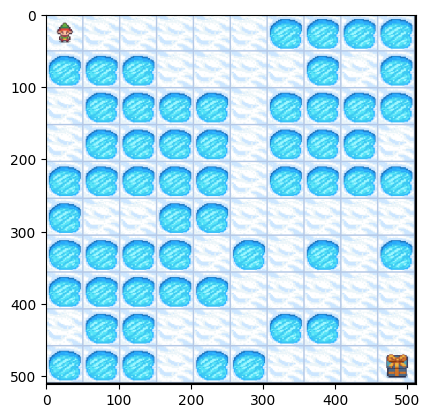

In [4]:
from IPython.display import display
random_map = generate_random_map(size=10, p=0.3)    
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
display(plt.gcf())
clear_output(wait=True)

In [102]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
%matplotlib inline
class QLearningAgent:
    def __init__(self, env, epsilon=1, learning_rate=0.5, discount_factor=0.97,\
                  max_epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.0001):
        self.memory = deque(maxlen=2500)
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.space_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.max_epsilon = max_epsilon            # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.epsilon_decay = 1 - epsilon_decay      # Exponential decay rate for exploration prob
        self.Q_table = np.zeros((self.space_size, self.action_size))
        self.rewards = []
        self.avg_rewards = []
        self.flattened_map = env.desc.flatten()
        self.successful_actions = []
        self.env.observation_space = tf.keras.utils.to_categorical(np.arange(self.space_size), num_classes=self.space_size)
        self.batch_size = 1024
        # ------------------------------------------------------------------------------------------------------
        # Open for interpretation
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()
        self.update_rate = 100
        self.goal_reached = False

    def build_model(self):
        model = Sequential([
            Dense(64, activation='relu', input_dim=self.space_size, use_bias=False),
            Dense(self.action_size, activation='linear',use_bias=False)])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=MeanSquaredError())
        return model
        # ------------------------------------------------------------------------------------------------------

    def add_memory(self, new_state, reward, done, state, action):
        self.memory.append((new_state, reward, done, state, action))

    def action(self, state):
        if random.random() < self.epsilon:
            random_val = np.random.randint(0,4)
            return random_val
        model_output = self.model.predict(state,verbose=0)
        return np.random.choice(np.flatnonzero(model_output == model_output.max()))
    
    def sample(self):
        sample = random.sample(self.memory, self.batch_size)
        next_states, rewards, done, states, actions = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(self.batch_size, -1)
        next_states = np.array(next_states).reshape(self.batch_size, -1)
        return states, actions, rewards, next_states, done

    def replay(self):

        states, actions, rewards, next_states, done = self.sample()
        targets = self.target_model.predict(states,verbose=0)
        next_q_values = self.target_model.predict(next_states,verbose=0)[range(self.batch_size),np.argmax(self.model.predict(next_states,verbose=0), axis=1)]
        targets[range(self.batch_size), actions] = rewards + (1-done) * next_q_values * self.discount_factor
        self.model.fit(x=states, y=targets,verbose=0)
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train(self, episodes=100):
        total_steps = 0
        for i, episode in enumerate(range(episodes)):
            total_steps += 1
            if total_steps % self.update_rate == 0:
                print("Updating Target Model")
                self.update_target_model()
                
            state = self.env.reset()[0]
            state_basic = state
            state_arr=np.zeros(self.space_size)
            state_arr[state] = 1
            state= np.reshape(state_arr, [1, self.space_size])
            done = False
            truncated = False
            score = 0
            actions = []
            # print('Episode:', i)
            steps = 0

            state_list = set()
            while not done and not truncated:
                # Take a random value between the range of 0-1, if it is less than our exploration rate probability then we take a random action
                #trade_off = random.uniform(0, 1)
                #if trade_off < self.epsilon:
                #    action = self.env.action_space.sample()
                #else:
                    # Selects action with the highest Q-value for the current state
                #    action = np.argmax(self.Q_table[state])
                # action = np.argmax(self.Q_table[state])
                if state_basic not in state_list:
                    state_list.add(state_basic)
                action = self.action(state)
                next_state, reward, done, truncated, info = self.env.step(action)
                # print(action)
                # print(next_state, reward, done, info, self.flattened_map[next_state])
                if next_state in state_list:
                    reward += -10
                elif next_state == state_basic and not done:
                    reward += -10
                elif self.flattened_map[next_state] == b'H':
                    reward += -10
                elif self.flattened_map[next_state] == b'G':
                    reward += 100
                elif self.flattened_map[next_state] == b'F':
                    reward += -1
                
                if reward > 0:
                    self.goal_reached = True
                
                self.Q_table[state_basic] = self.model.predict(state,verbose=0)
                state_basic = next_state
                new_state_arr = np.zeros(self.space_size)
                new_state_arr[next_state] = 1
                next_state = np.reshape(new_state_arr, [1, self.space_size])
                # print(next_state, reward, done, info, self.flattened_map[next_state])
                # Q(s,a)=(1−α)⋅Q(s,a)+α⋅(R+γ⋅maxa'Q(s',a'))

                self.add_memory(next_state, reward, done, state, action)
                #self.Q_table[state, action] = self.Q_table[state, action] + (self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state, :]) - self.Q_table[state, action]))
                
                #print(self.Q_table)
                score += reward
                state = next_state

                steps += 1

                actions.append(action)
                if self.flattened_map[state_basic] == b'G':
                    self.successful_actions.append((actions, score))

                if len(self.memory)> self.batch_size:
                    self.replay()
                #plt.imshow(self.env.render())
                #display(plt.gcf())
                #clear_output(wait=True)
                    # complete = True
                    # print(f"Episode {episode + 1} Score {score}")
            # self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate)*np.exp(-self.learning_rate_decay*episode)
            #self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.epsilon_decay*episode)
            self.rewards.append(score)
            self.avg_rewards.append(score/steps)
            print(f'Episode: {episode:4}/{episodes}. Eps: {float(self.epsilon):.2}, final step reward {reward}')
            if i % 50 == 0:
                print(self.Q_table)

            if i > 10 and reward > 0:
                last_5_avg = np.mean(self.rewards[-5:])
            # print('last 10 avg reward:', last_10_avg)
                if abs(score - last_5_avg) < 0.001: # early stopping
                    print('break diff', score - last_5_avg)
                    break
            # if i % 10000 == 0:
            # print(f"Episode {episode + 1} Score {score} Learning Rate {self.learning_rate} Exploration Probability {self.epsilon}")
            # print(self.learning_rate, self.epsilon)

    def greedy_render(self):
        solved = False
        while not solved:
            state = self.env.reset()[0]
            truncated = False
            done = False
            actions = []
            # print('Episode:', i)
            while not done and not truncated:

                action = np.argmax(self.Q_table[state])
                next_state, reward, done, truncated, info = self.env.step(action)
                plt.imshow(self.env.render())
                display(plt.gcf())
                clear_output(wait=True)

            if self.flattened_map[next_state] == b'G':
                solved = True

            # plt.imshow(self.env.render())
            # display(plt.gcf())
            # clear_output(wait=True)


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_353 (Dense)               │ (None, 64)             │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 4)              │           256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,656 (26.00 KB)

 Trainable params: 6,656 (26.00 KB)

 Non-trainable params: 0 (0.00 B)

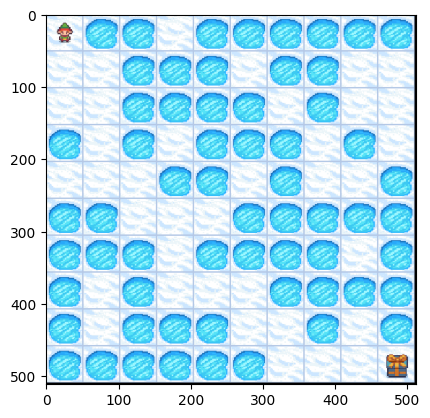

Episode:    0/5000. Eps: 1.0, final step reward -10.0
[[ 0.18507351 -0.01392669 -0.04052327  0.00677037]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0

KeyboardInterrupt: 

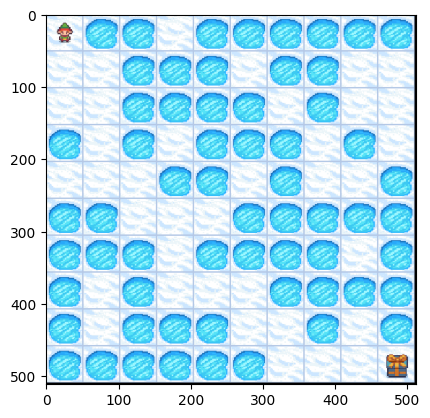

In [151]:
random_map = generate_random_map(size =10, p=0.3)    

env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=False)
env.reset()
agent = QLearningAgent(env)
plt.imshow(env.render())
display(plt.gcf())
# Train the agent
agent.train(episodes=5000)
print(agent.Q_table)


# Close the environment
env.close()


In [145]:
len(agent.successful_actions)

40

In [146]:
sorted(agent.successful_actions, key=lambda x: x[1], reverse=True)[0]

([1,
  1,
  1,
  2,
  2,
  3,
  1,
  2,
  2,
  3,
  2,
  2,
  2,
  0,
  2,
  1,
  1,
  0,
  2,
  1,
  2,
  1,
  1,
  2,
  1,
  1],
 76.0)

KeyboardInterrupt: 

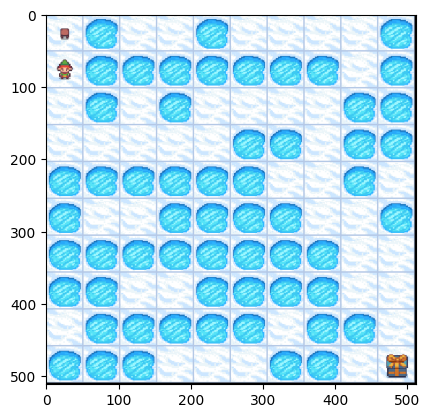

In [147]:
agent.greedy_render()

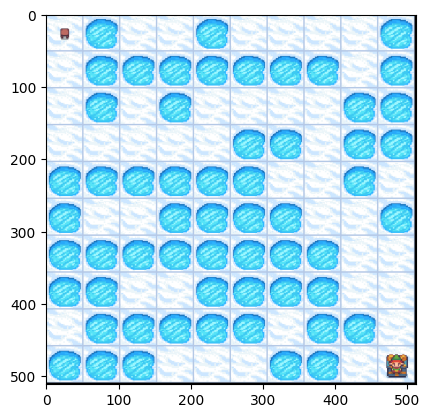

In [148]:
env.reset()
print(sorted(agent.successful_actions, key=lambda x: x[1], reverse=True)[0][0])
for action in sorted(agent.successful_actions, key=lambda x: x[1], reverse=True)[0][0]:
    print(action)
    env.step(action)
    plt.imshow(env.render())
    display(plt.gcf())
    clear_output(wait=True)
    # time.sleep(0.6)

In [149]:
max(agent.rewards)

76.0

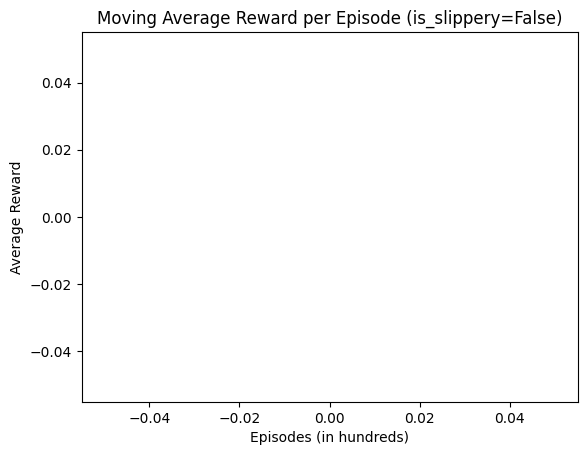

In [150]:
# plt.plot(agent.avg_rewards)
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward')
# plt.title('Average Reward per Episode')
# plt.show()
window_size = 1
moving_avg_rewards = [np.mean(agent.avg_rewards[i:i+window_size]) for i in range(0, len(agent.avg_rewards), window_size)]

plt.plot(moving_avg_rewards)
plt.xlabel('Episodes (in hundreds)')
plt.ylabel('Average Reward')
plt.title('Moving Average Reward per Episode (is_slippery=False)')
plt.show()

In [ ]:
%matplotlib inline
class QLearningAgentDistance:
    def __init__(self, env, exploration_probability=1, learning_rate=0.1, discount_factor=0.95,\
                  max_epsilon=1.0, min_epsilon=0.1, decay_rate=0.0001, \
                    max_learning_rate=0.9, min_learning_rate=0.1, decay_learning_rate=0.0001):
        self.env = env
        self.exploration_probability = exploration_probability
        self.learning_rate = learning_rate
        self.max_learning_rate = max_learning_rate
        self.min_learning_rate = min_learning_rate
        self.decay_learning_rate = decay_learning_rate
        self.discount_factor = discount_factor
        self.space_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.max_epsilon = max_epsilon            # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate = decay_rate      # Exponential decay rate for exploration prob
        self.Q_table = np.zeros((self.space_size, self.action_size))
        self.rewards = []
        self.avg_rewards = []
        self.flattened_map = env.desc.flatten()
        self.successful_actions = []
        self.goal_position = np.array(np.where(env.desc == b'G')).flatten()
        self.position = np.array(np.where(env.desc == b'S')).flatten()
        self.max_distance = np.abs(self.position - self.goal_position).sum()
        self.env.observation_space = tf.keras.utils.to_categorical(np.arange(env.observation_space.n), num_classes=env.observation_space.n)

        # ------------------------------------------------------------------------------------------------------
        # Open for interpretation
        self.model = Sequential([
            Dense(64, activation='relu', input_dim=self.space_size),
            Dense(64, activation='relu'),
            Dense(self.action_size, activation='linear')])
        self.model.compile(optimizer='Adam', loss=MeanSquaredError())
        # ------------------------------------------------------------------------------------------------------

    def train(self, episodes=100):
        print(self.goal_position)
        for i, episode in enumerate(range(episodes)):
            state = self.env.reset()[0]
            done = False
            truncated = False
            score = 0
            actions = []
            # print('Episode:', i)
            steps = 0
            while not done and not truncated:
                # print('self.position:', self.position)      
                # Take a random value between the range of 0-1, if it is less than our exploration rate probability then we take a random action
                trade_off = random.uniform(0, 1)
                if trade_off < self.exploration_probability:
                    action = self.env.action_space.sample()
                else:
                    # Selects action with the highest Q-value for the current state
                    action = np.argmax(self.Q_table[state])
                # action = np.argmax(self.Q_table[state])

                next_state, reward, done, truncated, info = self.env.step(action)
                # print(action)
                # print(next_state, reward, done, info, self.flattened_map[next_state])
                self.position = np.array([next_state // 10, next_state % 10])
                
                manhattan_distance = np.abs(self.position - self.goal_position).sum()
                dist_reward = manhattan_distance / self.max_distance

                if next_state == state and not done:
                    reward = -25
                if self.flattened_map[next_state] == b'H':
                    reward = -100
                if self.flattened_map[next_state] == b'G':
                    reward = 100
                if self.flattened_map[next_state] == b'F':
                    reward = -1
                    
                if reward < 0:
                    reward *= dist_reward
                # print(next_state, reward, done, info, self.flattened_map[next_state])
                # Q(s,a)=(1−α)⋅Q(s,a)+α⋅(R+γ⋅maxa'Q(s',a'))
                self.Q_table[state, action] = self.Q_table[state, action] + self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state, :]) - self.Q_table[state, action])

                score += reward
                state = next_state

                # print('manhattan_distance:', manhattan_distance)
                steps += 1

                actions.append(action)
                if self.flattened_map[next_state] == b'G':
                    self.successful_actions.append((actions, score))
            # plt.imshow(self.env.render())
            # display(plt.gcf())
            # clear_output(wait=True)
                    # complete = True
                    # print(f"Episode {episode + 1} Score {score}")
            self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate)*np.exp(-self.decay_learning_rate*episode)
            self.exploration_probability = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*episode)
            self.rewards.append(score)
            self.avg_rewards.append(score/steps)

    def greedy_render(self):
        solved = False
        while not solved:
            state = self.env.reset()[0]
            truncated = False
            done = False
            actions = []
            # print('Episode:', i)
            while not done and not truncated:

                action = np.argmax(self.Q_table[state])
                next_state, reward, done, truncated, info = self.env.step(action)
                plt.imshow(self.env.render())
                display(plt.gcf())
                clear_output(wait=True)

            if self.flattened_map[next_state] == b'G':
                solved = True
            # if i % 10000 == 0:
            # print(f"Episode {episode + 1} Score {score} Learning Rate {self.learning_rate} Exploration Probability {self.exploration_probability}")
            # print(self.learning_rate, self.exploration_probability)


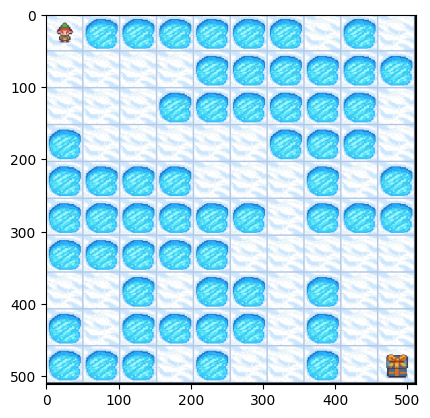

[9 9]
[[-3.75291215e+01 -5.64379559e+01 -5.41501652e+01 -6.12021877e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.58403885e+01 -3.46736045e+01 -3.63445613e+01 -3.67332490e+01]
 [-5.38954073e+01 -3.69655351e+01 -5.80244859e+01 -5.70802426e+01]
 [-5.38948444e+01 -4.63796115e+01 -6.09112860e+01 -5.59252229e+01]
 [-6.81039653e+01 -6.48281293e+01 -7.56868154e+01 -6.75151085e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

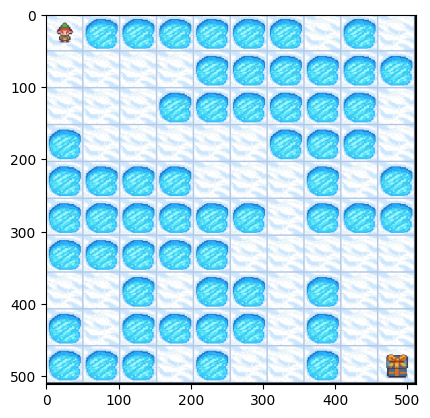

In [205]:
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=True)
env.reset()
agent = QLearningAgentDistance(env)
plt.imshow(env.render())
display(plt.gcf())
# Train the agent
agent.train(episodes=500_000)
print(agent.Q_table)


# Close the environment
env.close()

In [206]:
len(agent.successful_actions)

40

KeyboardInterrupt: 

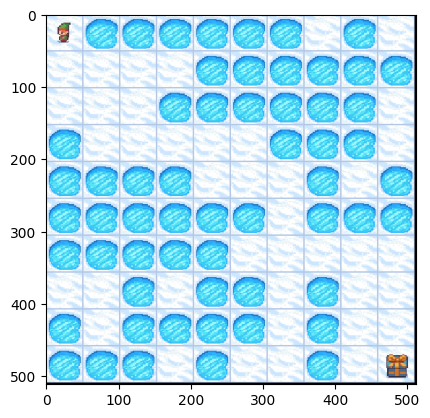

In [208]:
agent.greedy_render()

In [207]:
sorted(agent.successful_actions, key=lambda x: x[1], reverse=True)[0]

([2, 0, 3, 3, 0, 1, 1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2], 91.0)

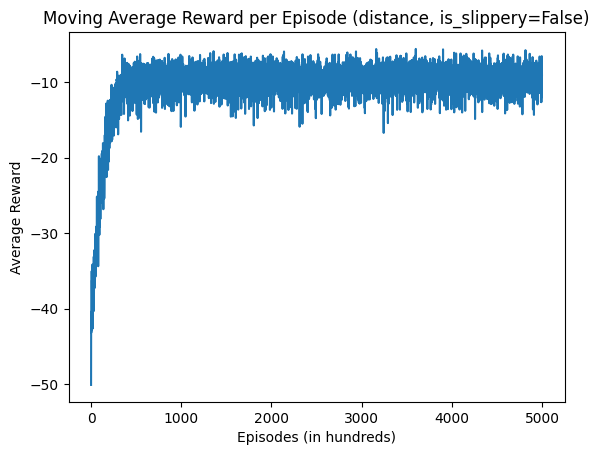

In [203]:
# plt.plot(agent.avg_rewards)
# plt.xlabel('Episodes')
# plt.ylabel('Average Reward')
# plt.title('Average Reward per Episode')
# plt.show()
window_size = 100
moving_avg_rewards = [np.mean(agent.avg_rewards[i:i+window_size]) for i in range(0, len(agent.avg_rewards), window_size)]

plt.plot(moving_avg_rewards)
plt.xlabel('Episodes (in hundreds)')
plt.ylabel('Average Reward')
plt.title('Moving Average Reward per Episode (distance, is_slippery=False)')
plt.show()